In [174]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
from graphdatascience import GraphDataScience
import networkx as nx
import imageio

#ignore specif warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

PROJECT_IMAGE_DIR = "./images"
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_IMAGE_DIR, "images_" + str(fig_id) + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=40)

In [2]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "s3cr3t"))

print(gds.version())

2.2.5


In [106]:
df_height = gds.run_cypher (
    """MATCH (s:Square)
    WITH s, s.lon AS lon, s.lat AS lat
    ORDER BY lon, lat
    RETURN s.elevation AS elevation""")
node_color = [row['elevation'] for index, row in df_height.iterrows()]
df_height = gds.run_cypher (
    """MATCH (s:Square)
    WITH s, s.lon AS lon, s.lat AS lat
    ORDER BY lon, lat
    RETURN lon AS x, lat AS y""")
pos = {index:(row['x'], row['y']) for index, row in df_height.iterrows()}

G = nx.DiGraph()
G.add_nodes_from(range(len(pos)))

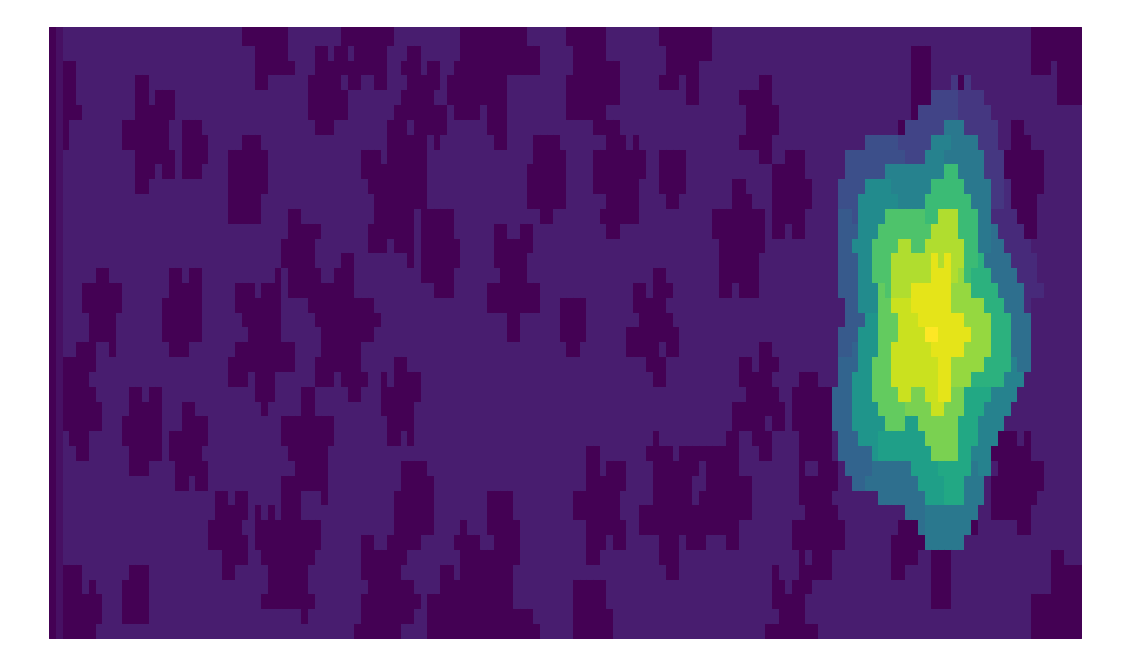

In [185]:
fig, ax = plt.subplots(figsize=(20,12))
nx.draw(G, pos=pos, ax=ax, edge_color = "grey", node_color=node_color, cmap=plt.cm.viridis, node_shape='s')

In [111]:
df_path = gds.run_cypher (
    """MATCH (source:Square&Initial), (target:Square&Destination)
CALL gds.shortestPath.dijkstra.stream('height_map', {
    sourceNode: source,
    targetNode: target
})
YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
WITH nodes(path) AS path
UNWIND path AS node
RETURN node.lat AS y, node.lon AS x
""")
path_pos = {"path_"+str(index):(row['x'], row['y']) for index, row in df_path.iterrows()}

In [194]:
def plot_frame(steps):
    path_pos = {"path_"+str(ix):(row['x'], row['y']) for ix, row in df_path.iterrows()}
    path_ix = {"path_"+str(ix):ix for ix, row in df_path.iterrows()}
    G_path = nx.DiGraph()
    G_path.add_nodes_from([ix for ix in path_pos.keys() if path_ix[ix] <= steps])
    fig, ax = plt.subplots(figsize=(15,7))
    nx.draw(G, pos=pos, ax=ax, edge_color = "grey", node_color=node_color, cmap=plt.cm.viridis, node_shape='s')
    nx.draw(G_path, pos=path_pos, ax=ax, edge_color = "grey", node_color='red', node_size=10)
    save_fig(steps,True)

Saving figure 473


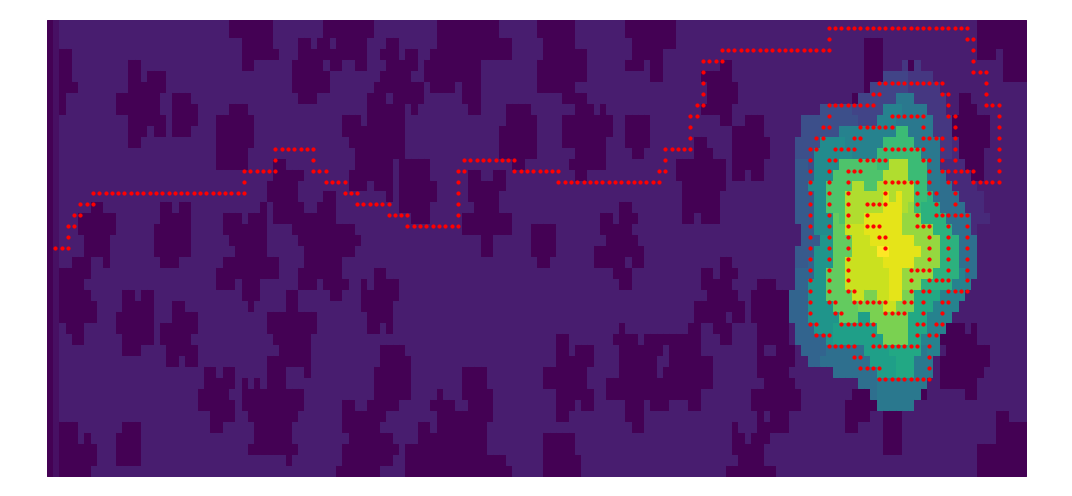

In [195]:
plot_frame(473)

In [ ]:
for i in range(474):
    plot_frame(i)

In [201]:
images = []
for t in range(474):
    image = imageio.imread(f'./images/images_{t}.png')
    images.append(image)

imageio.mimsave('./images/animation.gif', images, format='GIF', fps=40)